In [7]:
import sys
sys.path.insert(0, '../Utilities/')
import os

from scipy.interpolate import griddata
from pyDOE import lhs
from plotting import newfig, savefig
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.io
from pysr import PySRRegressor
import sympy 
import pandas as pd

In [8]:

# Carga los archivos .xlsx
file1 = '../DataExperiments/WT_in_LB_data_s1.XLSX'
file2 = '../DataExperiments/different_conditions_data_s2.XLSX'

# Lee las hojas de los archivos
df1 = pd.read_excel(file1, engine='openpyxl')  # Especifica la hoja si es necesario: sheet_name='nombre_hoja'
df2 = pd.read_excel(file2, engine='openpyxl')

# Cambiar la fila 0 a la nueva cabecera
df2.columns = df2.iloc[0]  # Establecer la primera fila como nueva cabecera
df2 = df2[1:]  # Eliminar la primera fila

# Reiniciar los índices (opcional, si quieres que empiece desde 0)
df2 = df2.reset_index(drop=True)

# Muestra los DataFrames
print("Archivo 1:")
display(df1)

print("Archivo 2:")
display(df2)


Archivo 1:


,Cycle Nr.,Time [s],Temp. [°C],G4,G5,G6,G7,G8,G9,G10,G11,G12,H1,H2,H3,H4,H5,H6
0,1,0.0,30.8,0.0922,0.0928,0.0928,0.0931,0.0928,0.0927,0.0916,0.0921,0.0911,0.0936,0.0925,0.0918,0.0929,0.0931,0.0931
1,2,678.6,30.7,0.0951,0.0957,0.0959,0.0959,0.0957,0.0953,0.0947,0.0951,0.0941,0.0970,0.0958,0.0951,0.0963,0.0963,0.0962
2,3,1357.1,30.4,0.0951,0.0958,0.0957,0.0960,0.0958,0.0954,0.0947,0.0951,0.0943,0.0971,0.0959,0.0952,0.0965,0.0964,0.0963
3,4,2035.7,30.2,0.0955,0.0962,0.0961,0.0965,0.0964,0.0958,0.0950,0.0957,0.0947,0.0975,0.0964,0.0957,0.0969,0.0969,0.0969
4,5,2714.2,30.0,0.0960,0.0969,0.0965,0.0968,0.0968,0.0964,0.0956,0.0963,0.0953,0.0981,0.0969,0.0961,0.0974,0.0973,0.0973
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494,495,335199.8,30.8,0.8186,0.8214,0.8188,0.8198,0.8221,0.8201,0.8296,0.8418,0.8292,0.4360,0.7711,0.8043,0.8181,0.8181,0.8153
495,496,335878.3,30.9,0.8184,0.8222,0.8185,0.8178,0.8201,0.8182,0.8277,0.8379,0.8274,0.4379,0.7729,0.8038,0.8198,0.8180,0.8154
496,497,336556.8,30.8,0.8183,0.8222,0.8169,0.8204,0.8214,0.8186,0.8287,0.8409,0.8289,0.4304,0.7719,0.8040,0.8187,0.8172,0.8154
497,498,337235.3,30.8,0.8172,0.8211,0.8194,0.8206,0.8227,0.8201,0.8303,0.8417,0.8280,0.4321,0.7717,0.8043,0.8194,0.8173,0.8143


Archivo 2:


,Cycle Nr.,Time [s],Temp. [°C],A1,A2,A3,A4,A5,A6,A7,...,H2,H3,H4,H5,H6,H7,H8,H9,H10,H11
0,1,0,30,0.0929,0.0971,0.0948,0.0961,0.0939,0.0934,0.0938,...,0.0913,0.0914,0.0924,0.0916,0.0925,0.0921,0.092,0.093,0.0927,0.093
1,2,678.6,30.5,0.0925,0.0962,0.0946,0.0953,0.0935,0.0931,0.0933,...,0.0913,0.0916,0.0926,0.092,0.0914,0.0921,0.0921,0.0931,0.0932,0.0925
2,3,1357.2,30.1,0.0926,0.0962,0.095,0.0954,0.0936,0.0932,0.0932,...,0.0916,0.0917,0.0927,0.0918,0.0917,0.0922,0.0923,0.0932,0.0932,0.0927
3,4,2035.8,30,0.0928,0.0981,0.0949,0.0956,0.0937,0.0934,0.0934,...,0.092,0.0921,0.0931,0.0922,0.0922,0.0928,0.0926,0.0936,0.0937,0.093
4,5,2714.4,30.3,0.0933,0.0985,0.0953,0.096,0.0942,0.0939,0.0938,...,0.0925,0.0927,0.0937,0.0928,0.093,0.0933,0.0933,0.0943,0.0944,0.0938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337,338,228685.2,29.9,0.5954,0.6453,0.6513,0.6593,0.6599,0.6576,0.5901,...,0.0926,0.0926,0.0935,0.0924,0.0949,1.0018,0.9769,0.9848,0.9871,0.9972
338,339,229363.7,29.8,0.5937,0.6448,0.6495,0.6568,0.6572,0.6564,0.5898,...,0.0926,0.0927,0.0934,0.0926,0.0953,1.0017,0.98,0.9857,0.9868,0.9976
339,340,230042.3,29.9,0.5923,0.6429,0.6487,0.6575,0.6589,0.6572,0.5889,...,0.0925,0.0925,0.0933,0.0923,0.0947,1.0009,0.9758,0.9833,0.9846,0.9963
340,341,230720.9,30.3,0.5912,0.6419,0.6484,0.6568,0.657,0.6548,0.5888,...,0.0923,0.0924,0.0932,0.0921,0.0942,1.0004,0.9763,0.9843,0.9845,0.9981


In [9]:
df2.iloc[:, 3:9]


,A1,A2,A3,A4,A5,A6
0,0.0929,0.0971,0.0948,0.0961,0.0939,0.0934
1,0.0925,0.0962,0.0946,0.0953,0.0935,0.0931
2,0.0926,0.0962,0.095,0.0954,0.0936,0.0932
3,0.0928,0.0981,0.0949,0.0956,0.0937,0.0934
4,0.0933,0.0985,0.0953,0.096,0.0942,0.0939
...,...,...,...,...,...,...
337,0.5954,0.6453,0.6513,0.6593,0.6599,0.6576
338,0.5937,0.6448,0.6495,0.6568,0.6572,0.6564
339,0.5923,0.6429,0.6487,0.6575,0.6589,0.6572
340,0.5912,0.6419,0.6484,0.6568,0.657,0.6548


In [10]:
c=-1
P_exp=np.array(df2.iloc[:, -5:])
T_exp=np.array(df2['Time [s]'])

T_max=max(T_exp)
T_exp=T_exp/max(T_exp)
N_exp=P_exp.shape[1]
N_exp,T_max, T_exp.shape, P_exp.shape

(5, 231399.5, (342,), (342, 5))

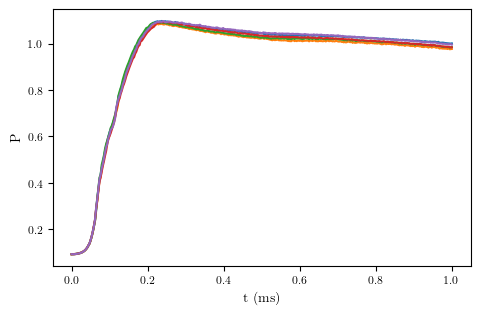

In [11]:
for i in range(N_exp):
    plt.plot(T_exp,P_exp[:, i])
plt.xlabel('t (ms)')
plt.ylabel('P ')
plt.show()

In [12]:
N_f = 1000 # Number of residual point
N_d = 500 #Number of data

P_star = P_exp.T.flatten().reshape([-1,1])
P0=P_exp[0,:]
T_meshgrid, P0_meshgrid, = np.meshgrid(T_exp, P0)
X_star = np.hstack((T_meshgrid.flatten()[:,None], P0_meshgrid.flatten()[:,None]))
u_star=np.hstack((P_star,P0_meshgrid.flatten()[:,None]))


# T_star = np.tile(T_exp,N_exp).reshape([-1,1])

# Doman bounds
lb = X_star.min(0)
lb[1]=lb[1]
ub = X_star.max(0) 
ub[1]=ub[1]


# Initial Condition
xx0 = X_star[::len(T_exp)]
uu0 = P_star[::len(T_exp)]

xx1= np.hstack((np.ones(len(P0)).reshape([-1,1]), P0.reshape([-1,1])))

xx01=np.vstack((xx0, xx1))
uu01=np.array([1]*N_exp+[0]*N_exp).reshape([-1,1])

# Additional data
idx = np.random.choice(P_star.shape[0], N_d-len(uu0), replace=False)
xxd = X_star[idx]
uud = P_star[idx]

X_u_train = np.concatenate((xx0,xxd))
P_train = np.concatenate((uu0,uud))

X_f_train = lb + (ub-lb)*lhs(2, N_f)
X_f_train = np.vstack((X_f_train, X_u_train))

X_u_train_tf = tf.convert_to_tensor(X_u_train, dtype=tf.float32)
P_train_tf =   tf.convert_to_tensor(P_train, dtype=tf.float32)
X_f_train_tf = tf.convert_to_tensor(X_f_train, dtype=tf.float32)
P_star_tf = tf.convert_to_tensor(P_star, dtype=tf.float32)
xx01_tf = tf.convert_to_tensor(xx01, dtype=tf.float32)
uu01_tf = tf.convert_to_tensor(uu01, dtype=tf.float32)

2024-11-27 12:22:08.086861: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-27 12:22:08.489847: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1077 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:08:00.0, compute capability: 7.5


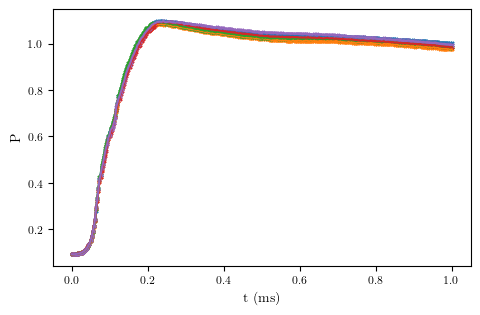

In [13]:
L_exp=len(P_exp[:,1])
for i in range(N_exp):
    plt.plot(X_star[L_exp*i:L_exp*(i+1)][:,0],P_exp[:, i])
    plt.scatter(X_star[L_exp*i:L_exp*(i+1)][:,0],P_star[L_exp*i:L_exp*(i+1)], marker='x', s=5)

plt.xlabel('t (ms)')
plt.ylabel('P ')
plt.show()

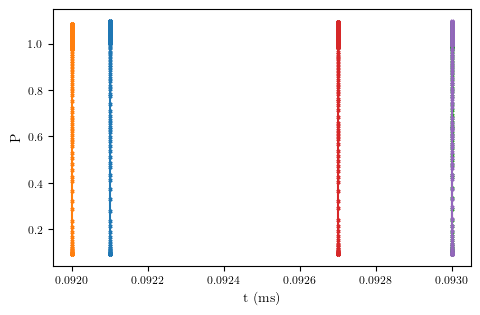

In [14]:
L_exp=len(P_exp[:,1])
for i in range(N_exp):
    plt.plot(X_star[L_exp*i:L_exp*(i+1)][:,1],P_exp[:, i])
    plt.scatter(X_star[L_exp*i:L_exp*(i+1)][:,1],P_star[L_exp*i:L_exp*(i+1)], marker='x', s=5)

plt.xlabel('t (ms)')
plt.ylabel('P ')
plt.show()

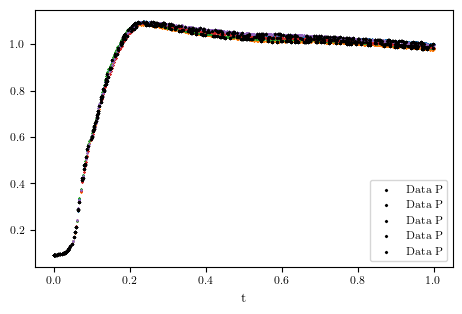

In [15]:
L_exp=len(P_exp[:,1])
for i in range(N_exp):
    plt.scatter(X_star[L_exp*i:L_exp*(i+1)][:,0],P_star[L_exp*i:L_exp*(i+1)], marker='x', s=1)
    plt.scatter(X_u_train[:,0], P_train, marker='x', s=2, color='black',label='Data P')

plt.legend()
plt.xlabel('t')
# plt.ylabel('P')
# plt.savefig('figures/P_phi.pdf')
plt.show()

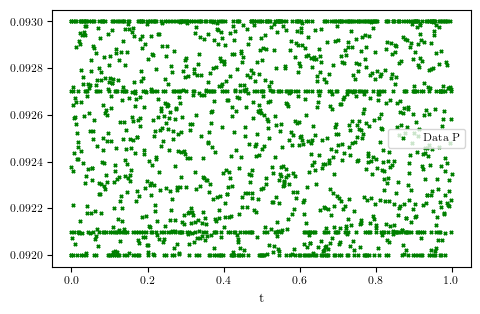

In [16]:

plt.scatter(X_f_train_tf[:,0], X_f_train_tf[:,1], s=5, marker='x', color='green',label='Data P')


plt.legend()
plt.xlabel('t')
# plt.ylabel('P')
# plt.savefig('figures/P_phi.pdf')
plt.show()

In [17]:
np.random.seed(seed=1234)
tf.random.set_seed(1234)
tf.config.experimental.enable_tensor_float_32_execution(False)
#os.environ[‘TF_ENABLE_AUTO_MIXED_PRECISION’] = ‘1’



# Initalization of Network
def hyper_initial(size):
    in_dim = size[0]
    out_dim = size[1]
    std = np.sqrt(2.0/(in_dim + out_dim))
    return tf.Variable(tf.random.truncated_normal(shape=size, stddev = std))

# Neural Network 
def DNN(X, W, b):
    A = 2.0*(X - lb)/(ub - lb) - 1.0
    L = len(W)
    for i in range(L-1):
        A = tf.tanh(tf.add(tf.matmul(A, W[i]), b[i]))
    Y = tf.add(tf.matmul(A, W[-1]), b[-1])
    return Y

def train_vars(W, b):
    return W + b 


def net(t, w, b):
    p = DNN(t, w, b)
    return p

def loss_weight(N_r, N_b):
    alpha_b = tf.Variable(tf.reshape(tf.repeat(1000.0, N_b), (N_b, -1))) 
    alpha_r = tf.Variable(tf.ones(shape=[N_r, 2]), dtype=tf.float32)
    alpha_0 = tf.Variable(tf.reshape(tf.repeat(1000.0, N_exp*2), (N_exp*2, -1))) 
    return alpha_r, alpha_b, alpha_0


#@tf.function(jit_compile=True)
@tf.function()
def net_f(X_f, W_p, b_p, W_phi, b_phi, lnv):
    with tf.GradientTape(persistent=True) as tape1:
        tape1.watch([X_f])
        u=net(X_f, W_p, b_p)

        lnp=u[:,0:1]
        lns=u[:,1:2]

        p=tf.exp(lnp)
        s=tf.exp(lns)
        m=tf.exp(lnv[0:1])
        l=tf.exp(lnv[1:2])


        phi=tf.exp(net(tf.concat([p, s],1), W_phi, b_phi))


    p_t = tape1.gradient(p, X_f)[...,0:1]
    s_t = tape1.gradient(s, X_f)[...,0:1]

    f_p = p_t - phi*p + l*p
    f_s = s_t + m*p*s
    
    return f_p, f_s




#@tf.function()
@tf.function()
def train_step(W_p, b_p,  W_phi, b_phi,  X_u_train_tf, P_train_tf, X_f_train_tf, xx01_tf, uu01_tf, lambda_r, lambda_b, lambda_0, lnv, opt):

    with tf.GradientTape(persistent=True) as tape:
        tape.watch([W_p, b_p, W_phi, b_phi, lambda_b, lambda_r, lambda_0, lnv])
        u_nn = net(X_u_train_tf, W_p, b_p) 
        lnp=u_nn[:,0:1]
        p_nn=tf.exp(lnp)
        f_p, f_s = net_f(X_f_train_tf, W_p, b_p, W_phi, b_phi, lnv)

        u_00 = net(xx01_tf, W_p, b_p) 
        lns_0=u_00[:,1:2]
        s_00=tf.exp(lns_0)


        loss_p = tf.square(lambda_b*(p_nn - P_train_tf))
        loss_0s = tf.square(lambda_0*(s_00 - uu01_tf))
        loss_fp = tf.square(lambda_r[0:1]*f_p) 
        loss_fs = tf.square(lambda_r[1:2]*f_s) 


        loss =  tf.reduce_mean(loss_p) + tf.reduce_mean(loss_fp)+ tf.reduce_mean(loss_fs)+ tf.reduce_mean(loss_0s)

    grads_p = tape.gradient(loss, train_vars(W_p, b_p))
    grads_phi = tape.gradient(loss, train_vars(W_phi, b_phi))
    grads_lnv = tape.gradient(loss, lnv)
    grads_u = tape.gradient(loss, lambda_r)
    grads_b = tape.gradient(loss, lambda_b)
    grads_0 = tape.gradient(loss, lambda_0)


    opt.apply_gradients(zip(grads_p, train_vars(W_p, b_p)))
    opt.apply_gradients(zip(grads_phi, train_vars(W_phi, b_phi)))
    opt.apply_gradients(zip([grads_lnv], [lnv]))
    opt.apply_gradients(zip([-grads_u], [lambda_r]))
    opt.apply_gradients(zip([-grads_b], [lambda_b]))
    opt.apply_gradients(zip([-grads_0], [lambda_0]))

   
    return loss, tf.reduce_mean(tf.square((p_nn - P_train_tf))), tf.reduce_mean(tf.square(f_p)), tf.reduce_mean(tf.square(f_s))


layers = [2, 20, 20, 2]

L = len(layers)
W_p = [hyper_initial([layers[l-1], layers[l]]) for l in range(1, L)] 
b_p = [tf.Variable(tf.zeros([1, layers[l]])) for l in range(1, L)]

layers = [2, 20, 20, 1]


W_phi = [hyper_initial([layers[l-1], layers[l]]) for l in range(1, L)] 
b_phi = [tf.Variable(tf.zeros([1, layers[l]])) for l in range(1, L)]

lnv = tf.Variable(tf.reshape(tf.repeat(1.0, 2), (2, -1)), dtype=tf.float32) 
lambda_r, lambda_b, lambda_0 = loss_weight(N_f, N_d)



In [18]:
lr = 2e-3
# Nmax = 15000
# Nmax = 150000
Nmax=3*10**5
# Nmax=20000



optimizer = tf.optimizers.Adam(learning_rate=lr)
optimizer2 = tf.optimizers.Adam(learning_rate=lr/10)
# optimizer3 = tf.optimizers.Adam(learning_rate=lr/100)
# optimizer3 = tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9)
optimizer3 = tf.optimizers.Adam(learning_rate=lr/50)

# optimizer3 = tf.keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9, clipnorm=10.0)


start_time = time.time()
n=0
loss = []
loss_d = []
loss_fisp = []
loss_fiss = []
loss_reg=[]
# loss_fisa = []

# Make a new Function and ConcreteFunction for each optimizer.
train_step_1 = tf.function(train_step).get_concrete_function(W_p, b_p, W_phi, b_phi, X_u_train_tf, P_train_tf, X_f_train_tf, xx01_tf, uu01_tf,  lambda_r, lambda_b, lambda_0, lnv, optimizer)
train_step_2 = tf.function(train_step).get_concrete_function(W_p, b_p, W_phi, b_phi, X_u_train_tf, P_train_tf, X_f_train_tf, xx01_tf, uu01_tf, lambda_r, lambda_b, lambda_0, lnv, optimizer)
train_step_3 = tf.function(train_step).get_concrete_function(W_p, b_p, W_phi, b_phi, X_u_train_tf, P_train_tf, X_f_train_tf, xx01_tf, uu01_tf, lambda_r, lambda_b, lambda_0, lnv, optimizer)


In [19]:
Nmax=3*10**5


while n <= Nmax:
    if n<10**5:
        loss_, loss_p, loss_fp, loss_fs = train_step_1(W_p, b_p, W_phi, b_phi, X_u_train_tf, P_train_tf, X_f_train_tf, xx01_tf, uu01_tf, lambda_r, lambda_b, lambda_0, lnv)
    elif n< 2*10**5:
        loss_, loss_p, loss_fp, loss_fs = train_step_2(W_p, b_p, W_phi, b_phi, X_u_train_tf, P_train_tf, X_f_train_tf, xx01_tf, uu01_tf, lambda_r, lambda_b, lambda_0, lnv)
    else:
        loss_, loss_p, loss_fp, loss_fs = train_step_3(W_p, b_p, W_phi, b_phi, X_u_train_tf, P_train_tf, X_f_train_tf, xx01_tf, uu01_tf, lambda_r, lambda_b, lambda_0, lnv)

    loss.append(loss_)
    loss_d.append(loss_p)
    loss_fisp.append(loss_fp)
    loss_fiss.append(loss_fs)
    # loss_fisa.append(loss_fa)



    if n % 10 == 0:

        print(f"Iteration is: {n}")
        print(f"Total loss is: {loss_}")
        print(f"Data loss is: {loss_p}")
        print(f"Physicial loss of p is: {loss_fp}")
        print(f"Physicial loss of s is: {loss_fs}")
        # if n%10000 ==0:
        #     loss_reg_=eval(W_p, b_p, W_phi_s, b_phi_s)
        #     loss_reg.append(loss_reg_)
        # print(f"Physicial loss of a is: {loss_fa}")

    n+=1

elapsed = time.time() - start_time                
print('Training time: %.4f' % (elapsed))

Iteration is: 0
Total loss is: 619785.5625
Data loss is: 0.08579923957586288
Physicial loss of p is: 6.26748514175415
Physicial loss of s is: 6.974315166473389
Iteration is: 10
Total loss is: 241835.625
Data loss is: 0.05483892932534218
Physicial loss of p is: 3.015981674194336
Physicial loss of s is: 1.751139760017395
Iteration is: 20
Total loss is: 120159.1875
Data loss is: 0.054162632673978806
Physicial loss of p is: 0.0742872953414917
Physicial loss of s is: 0.531138002872467
Iteration is: 30
Total loss is: 74830.609375
Data loss is: 0.05259181186556816
Physicial loss of p is: 0.007733362726867199
Physicial loss of s is: 0.03569313883781433
Iteration is: 40
Total loss is: 59688.578125
Data loss is: 0.05125129222869873
Physicial loss of p is: 0.020749228075146675
Physicial loss of s is: 0.02343975380063057
Iteration is: 50
Total loss is: 56013.1875
Data loss is: 0.05072685331106186
Physicial loss of p is: 0.07401083409786224
Physicial loss of s is: 0.08930356055498123
Iteration is: 

KeyboardInterrupt: 

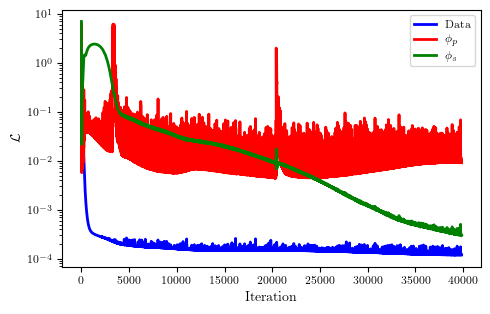

In [20]:
Nmax=len(loss)
it = np.arange(0,Nmax, 1)
loss_list = [loss[i].numpy() for i in range(0,Nmax)]
loss_data_list = [loss_d[i].numpy() for i in range(0,Nmax)]

loss_phip_list = [loss_fisp[i].numpy() for i in range(0,Nmax)]
loss_phis_list = [loss_fiss[i].numpy() for i in range(0,Nmax)]



plt.semilogy(it, np.asarray(loss_data_list), 'b-', linewidth = 2, label = 'Data')  
plt.semilogy(it, np.asarray(loss_phip_list), 'r-', linewidth = 2, label = '$\phi_p$')    
plt.semilogy(it, np.asarray(loss_phis_list), 'g-', linewidth = 2, label = '$\phi_s$')       


plt.xlabel('Iteration')
plt.ylabel('$\mathcal{L}$')  
plt.legend()  
# plt.savefig('figures/loss_phi.pdf')
plt.show()

In [21]:
lnv[0], tf.exp(lnv[0]), lnv[1], tf.exp(lnv[1])

(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([2.830277], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([16.950155], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.2152831], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.2402129], dtype=float32)>)

In [22]:
def predict(X_star_tf, w, b):
    u_pred = net(X_star_tf, w, b)
    return u_pred

## Evaluating total function
X_star_tf = tf.convert_to_tensor(X_star, dtype=tf.float32)    
u_pred = predict(X_star_tf, W_p, b_p)

# ## Evaluating unknown function
lnp=u_pred[:,0:1]
lns=u_pred[:,1:2]

p=tf.exp(lnp)
s=tf.exp(lns)

phi = tf.exp(predict(tf.concat([p, s],1), W_phi, b_phi))

m=tf.exp(lnv[0:1])
l=tf.exp(lnv[1:2])


phi_s=-np.array(p*s*m)


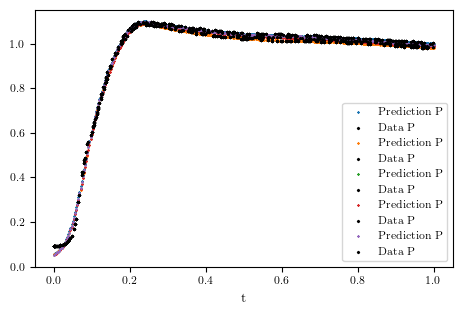

In [23]:
for i in range(N_exp):
    plt.scatter(X_star_tf[L_exp*i:L_exp*(i+1)][:,0], p[L_exp*i:L_exp*(i+1)], marker='x', s=1,  label='Prediction P')
    plt.scatter(X_u_train[:,0], P_train, marker='x', s=2, color='black',label='Data P')

plt.legend()
plt.xlabel('t')
# plt.ylabel('P')
# plt.savefig('figures/P_phi.pdf')
plt.show()

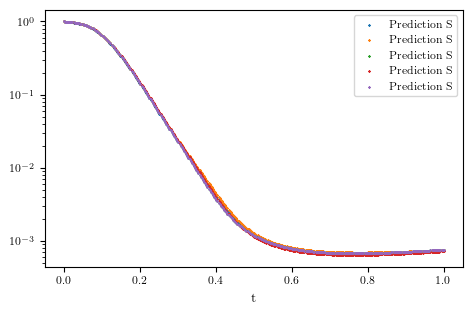

In [24]:
for i in range(N_exp):
    plt.scatter(X_star_tf[L_exp*i:L_exp*(i+1)][:,0], s[L_exp*i:L_exp*(i+1)], marker='x', s=1,  label='Prediction S')


plt.legend()
plt.xlabel('t')
plt.yscale('log')
# plt.xscale('log')

# plt.ylabel('P')
# plt.savefig('figures/P_phi.pdf')
plt.show()

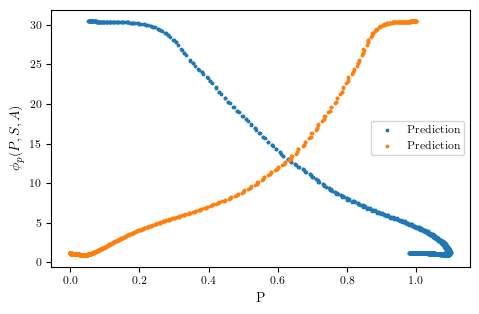

In [25]:
plt.scatter(p, phi, s=3, label='Prediction')
plt.scatter(s, phi, s=3, label='Prediction')

# plt.plot(u_pred[:,1:2], phi_pred, label='Prediction')

# plt.scatter(X_u_train, u_train, marker='x', color='black',label='Data')
# plt.scatter(X_f_train, np.zeros(len(X_f_train)), marker='x')
plt.legend()
plt.xlabel('P')
plt.ylabel('$\phi_p(P,S,A)$')
# plt.savefig('figures/phi.pdf')
plt.show()

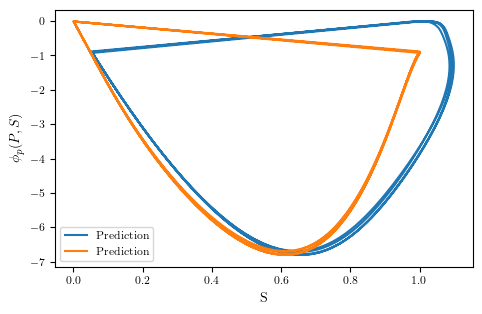

In [26]:
plt.plot(p, phi_s, label='Prediction')

plt.plot(s, phi_s, label='Prediction')

# plt.scatter(X_u_train, u_train, marker='x', color='black',label='Data')
# plt.scatter(X_f_train, np.zeros(len(X_f_train)), marker='x')
plt.legend()
plt.xlabel('S')
plt.ylabel('$\phi_p(P,S)$')
# plt.savefig('figures/phi.pdf')
plt.show()

In [27]:
P0, np.mean(P0)


(array([0.09210000187158585, 0.09200000017881393, 0.09300000220537186,
        0.09269999712705612, 0.09300000220537186], dtype=object),
 0.09256000071763992)

In [31]:
np.mean(P0)

0.09256000071763992

In [41]:
Nt=1000
T_int=np.zeros(Nt)
P_int=np.zeros(Nt)
S_int=np.zeros(Nt)


dt=0.001

T_int[0]=0
P_int[0]=np.mean(P0-0.03) #Initial conditions
# P_int[0]=np.array(p[0]) #Initial conditions

S_int[0]=np.array(s[0]) #Initial conditions



for i in range(1,Nt):

    PS=tf.concat([tf.convert_to_tensor(P_int[i-1].reshape([-1,1]), dtype=tf.float32),tf.convert_to_tensor(S_int[i-1].reshape([-1,1]), dtype=tf.float32)],1)

    PHI_S=tf.exp(predict(PS , W_phi, b_phi))

    P_int[i]=P_int[i-1]+(P_int[i-1]*PHI_S - P_int[i-1]*np.array(l))*dt
    S_int[i]=S_int[i-1]-P_int[i-1]*S_int[i-1]*np.array(m)*dt
    T_int[i]=T_int[i-1]+dt

In [42]:
l

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1.2402129]], dtype=float32)>

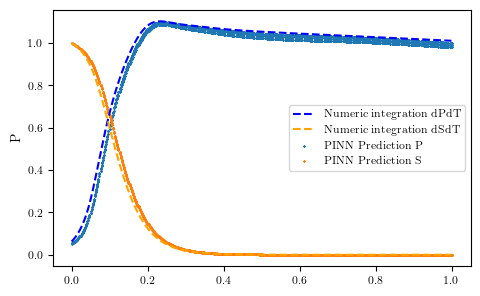

In [43]:
plt.plot(T_int, P_int, color='blue', linestyle='--', label='Numeric integration dPdT')
plt.plot(T_int, S_int, color='orange', linestyle='--', label='Numeric integration dSdT')


plt.scatter(X_star_tf[:,0], p, marker='x', s=1,  label='PINN Prediction P')
plt.scatter(X_star_tf[:,0], s, marker='x', s=1,  label='PINN Prediction S')
# plt.xlabel('t')
plt.ylabel('P')
plt.legend()
plt.show()

# Symbolic Regresion

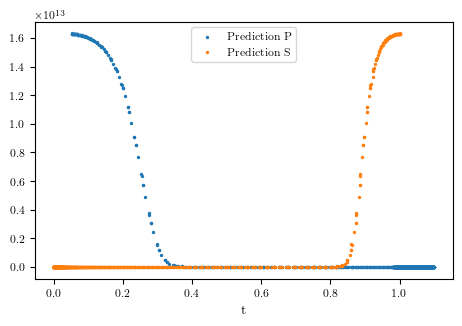

(<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.    , 0.0921], dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.9970674, 0.093    ], dtype=float32)>)

In [122]:
c=0
d=-1
plt.scatter( p[c:d], np.exp(phi[c:d]), s=2, label='Prediction P')
plt.scatter( s[c:d], np.exp(phi[c:d]), s=2, label='Prediction S')
# plt.plot( a[c:d], phi_p[c:d], label='Prediction S')


plt.legend()
plt.xlabel('t')
# plt.ylabel('P')
# plt.savefig('figures/P_phi.pdf')
plt.show()
X_star_tf[c:d][0], X_star_tf[c:d][-1]

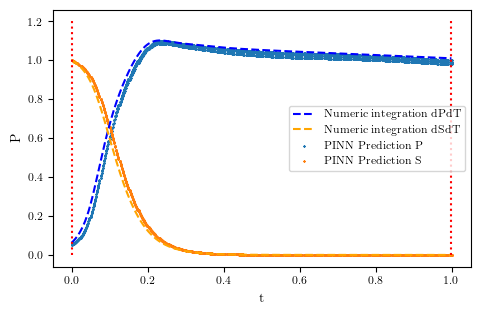

In [123]:
plt.plot(T_int, P_int, color='blue', linestyle='--', label='Numeric integration dPdT')
plt.plot(T_int, S_int, color='orange', linestyle='--', label='Numeric integration dSdT')




plt.scatter(X_star_tf[:,0], p, marker='x', s=1,  label='PINN Prediction P')
plt.scatter(X_star_tf[:,0], s, marker='x', s=1,  label='PINN Prediction S')


plt.vlines(X_star_tf[c:d][:,0][0],0,1.2, color='red', linestyle=':')
plt.vlines(X_star_tf[c:d][:,0][-1],0,1.2, color='red', linestyle=':')


plt.xlabel('t')
plt.ylabel('P')
plt.legend()
plt.show()

In [129]:
model = PySRRegressor(
    niterations=200,
    binary_operators=["+", "*", "inv(x, y) = x/(x + y)"],
    # binary_operators=["+", "*", "inv(x, y) = x/(x + y)", "^"],

    # unary_operators=[ "exp"],
    # unary_operators=["inv(x) = 1/x"],
    extra_sympy_mappings={
            "inv": lambda x, y: x/(x+y),
        },
    # extra_sympy_mappings={"inv": lambda x: 1/x},
    constraints={"exp": 3, 'inv': (1, 1)},
    # complexity_of_operators={"/": 2},
    parsimony=0.00000001,
    # denoise=True,
    # complexity_of_variables=2,
    # complexity_of_constants=2,
    elementwise_loss="loss(prediction, target) = (prediction - target)^2",
    random_state=42,   # Fija la semilla
    # select_k_features=1,
    maxsize=40,
)

In [130]:
# p1s=tf.concat([p1[c:d], s[c:d]], axis=1)

min_cols_phi= tf.math.reduce_min(phi[c:d], axis=0)
max_cols_phi= tf.math.reduce_max(phi[c:d], axis=0)

phi_scaled = (phi[c:d]-min_cols_phi)/(max_cols_phi-min_cols_phi)
PS_tf=tf.concat([p[c:d], s[c:d]],1)

model.fit( PS_tf,phi_scaled)
print(model)


c:\Users\u256063\AppData\Local\anaconda3\envs\tf2.8\lib\site-packages\pysr\sr.py:1310: UserWarning: Note: Setting `random_state` without also setting `deterministic` to True and `procs` to 0 will result in non-deterministic searches. 
  warnings.warn(
c:\Users\u256063\AppData\Local\anaconda3\envs\tf2.8\lib\site-packages\pysr\sr.py:2582: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 7.740e+04
Head worker occupation: 28.6%
Progress: 178 / 3000 total iterations (5.933%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           3.940e-03  1.594e+01  y = x₁
3           1.396e-03  5.188e-01  y = x₁ * x₁
5           5.295e-04  4.846e-01  y = x₁ * (0.094901 + x₁)
7           4.815e-04  4.752e-02  y = ((0.084183 + x₁) * x₁) + 0.0076845
9           4.814e-04  7.624e-05  y = ((0.084183 + x₁) * x₁) + (0.0076845 * x₀)
11          1.879e-04  4.705e-01  y = x₁ * (0.33539 + ((x₁ * x₁) * inv(x₀, 0.029853)))
13          1.364e-04  1.601e-01  y = x₁ * (0.4574 + ((x₁ * (x₁ * x₁)) * inv(x₀, 0.050229)))
15          1.222e-04  5.497e-02  y = x₁ * (0.41682 + (((x₁ * x₁) * x₁) * (inv(x₀, 0.10514) + 0....
                                  21446)))
19          1.113e-04  2.334e-02  y = (0.46678 + ((inv(x₀, 0.058055) + x₀) * ((x₁ * x₁) * (-0.07...


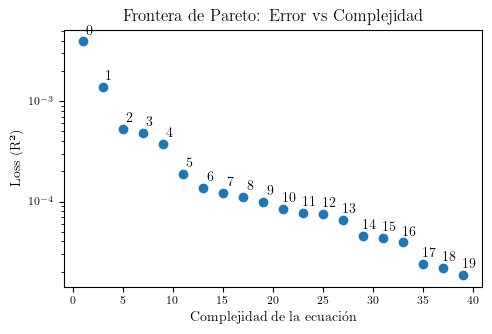

In [134]:
# Extraer las métricas de las ecuaciones
equations_df = model.equations_
# Obtener la complejidad y la puntuación (score) de cada ecuación
complejidades = equations_df['complexity']
errores = equations_df['loss']  # Por ejemplo, error MSE o cualquier métrica utilizada

# Crear el gráfico de dispersión
plt.scatter(complejidades, errores)

# Añadir etiquetas de índice en cada punto
for i, (x, y) in enumerate(zip(complejidades, errores)):
    plt.annotate(i, (x, y), textcoords="offset points", xytext=(5,5), ha='center')

# Añadir etiquetas y título
plt.xlabel('Complejidad de la ecuación')
plt.ylabel('Loss (R²)')
plt.title('Frontera de Pareto: Error vs Complejidad')

# Mostrar gráfico
plt.yscale('log')
plt.show()

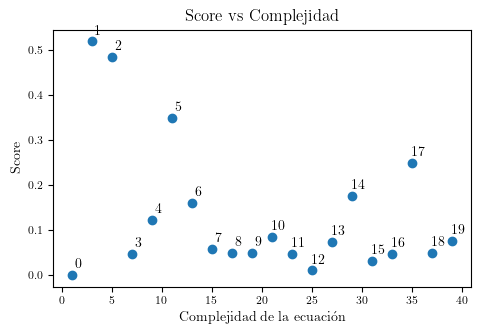

In [135]:
# Extraer complejidad y score
complejidades = equations_df['complexity']
scores = equations_df['score']

# Graficar score vs complejidad
plt.scatter(complejidades, scores)

# Añadir etiquetas de índice en cada punto
for i, (x, y) in enumerate(zip(complejidades, scores)):
    plt.annotate(i, (x, y), textcoords="offset points", xytext=(5,5), ha='center')


plt.xlabel('Complejidad de la ecuación')
plt.ylabel('Score')
plt.title('Score vs Complejidad')
plt.show()


In [210]:
chose=2
expr=model.sympy(chose)*(max_cols_phi-min_cols_phi)+min_cols_phi
expr

29.4935264587402*x1*(x1 + 0.09490727) + 0.929558753967285

In [211]:
sympy.expand(expr)

29.4935264587402*x1**2 + 2.7991500788718*x1 + 0.929558753967285

In [212]:
sympy.simplify(expr)


29.4935264587402*x1*(x1 + 0.09490727) + 0.929558753967285

In [213]:
sympy.factor(expr)


29.4935264587402*(1.0*x1**2 + 0.09490727*x1 + 0.0315173824760388)

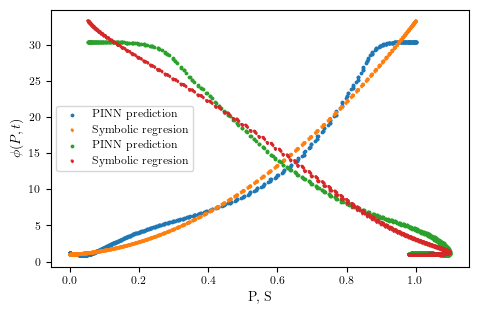

In [214]:
symb_s=model.predict(tf.concat([p, s],1),chose)
symb_s=symb_s*(max_cols_phi-min_cols_phi)+min_cols_phi
plt.scatter(s, phi, s=3, label='PINN prediction')
plt.scatter(s, symb_s, s=3,  linestyle='--', label='Symbolic regresion')
plt.scatter(p, phi, s=3, label='PINN prediction')
plt.scatter(p, symb_s, s=3,  linestyle='--', label='Symbolic regresion')
# plt.plot(tf.concat([p, s],1), 15.38-1.18*s, linestyle='--', label=r'$s\approx 0$')

# plt.plot( s, 200/(13+s), label='Real S')

plt.xlabel('P, S')
plt.ylabel('$\phi (P,t)$')
plt.legend()
plt.show()

In [215]:
m, l

(<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[16.950155]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1.2402129]], dtype=float32)>)

In [221]:
Nt=1000
P_symb=np.zeros(Nt)
T_symb=np.zeros(Nt)
S_symb=np.zeros(Nt)

dt=0.001

P_symb[0]=np.mean(P0) #Initial conditions
# P_symb[0]=np.mean(1) #Initial conditions

S_symb[0]=np.array(s[0]) #Initial conditions
T_symb[0]=0
for i in range(1,Nt):
    PS_p=tf.concat([tf.convert_to_tensor(P_symb[i-1].reshape([-1,1]), dtype=tf.float32),tf.convert_to_tensor(S_symb[i-1].reshape([-1,1]), dtype=tf.float32)],1)
    # PHI=predict(PS_p , W_phi, b_phi)
    # P_symb[i]=P_symb[i-1]+(PHI)*P_symb[i-1]*dt

    P_symb[i]=P_symb[i-1]+(model.predict(PS_p,chose)*(max_cols_phi-min_cols_phi)+min_cols_phi-np.array(l-0.2))*P_symb[i-1]*dt
    S_symb[i]=S_symb[i-1]-np.maximum(0, P_symb[i-1]*S_symb[i-1]*np.array(m))*dt
    T_symb[i]=T_symb[i-1]+dt

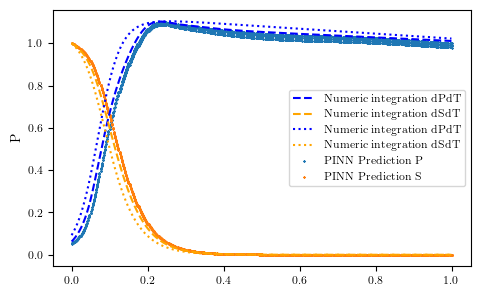

In [222]:
plt.plot(T_int, P_int, color='blue', linestyle='--', label='Numeric integration dPdT')
plt.plot(T_int, S_int, color='orange', linestyle='--', label='Numeric integration dSdT')

plt.plot(T_symb, P_symb, color='blue', linestyle=':', label='Numeric integration dPdT')
plt.plot(T_symb, S_symb, color='orange', linestyle=':', label='Numeric integration dSdT')

plt.scatter(X_star_tf[:,0], p, marker='x', s=1,  label='PINN Prediction P')
plt.scatter(X_star_tf[:,0], s, marker='x', s=1,  label='PINN Prediction S')
# plt.xlabel('t')
plt.ylabel('P')
plt.legend()
plt.show()

In [ ]:
m, l

(<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[16.950155]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1.2402129]], dtype=float32)>)

Soluciones de f(S) = 0: [0.03002964 0.03002964 0.03002964 0.03002964 0.03002964 0.03002964
 0.03002964 0.03002964 0.03002964]


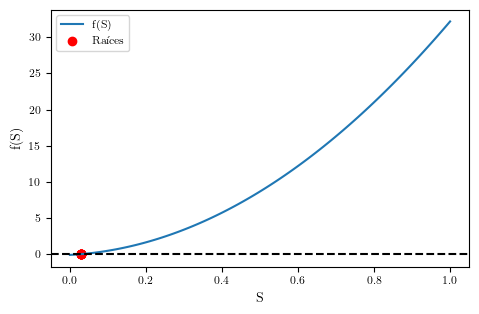

In [224]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
import sympy as sp

P, S = sp.symbols('P S')

# Convertir l y m a valores numéricos
l_val = float(l.numpy()-0.2)
m_val = float(m.numpy())

# Definir la función que representa el sistema de ecuaciones
def system(vars):
    P, S = vars
    f_S = expr.subs({'x0':P,'x1': S})-l_val  # Cambia esta expresión por la de tu función f(S)
    dP = f_S * P 
    dS = -m_val * S * P
    return [dP, dS]


# Definir variables simbólicas
# P, S = sp.symbols('P S')
# Define tu función f(S) y asegúrate de que solo depende de S
f_S = expr.subs({'x0':P,'x1': S}) - l_val  # Actualizar f(S) con l

# Convertir f(S) a función numérica
f_S_func = sp.lambdify(S, f_S, 'numpy')

# Rango para el diagrama de fases
S_values = np.linspace(0, max(s), 50)
P_values = np.linspace(0, max(p), 50)

# Crear la cuadrícula
P_grid, S_grid = np.meshgrid(P_values, S_values)
dP_vals = f_S_func(S_grid) * P_grid
dS_vals = -m_val * S_grid * P_grid

# Encontrar los puntos fijos usando fsolve
fixed_points = []
for P_init in np.linspace(0, max(p), 50):  # Asegúrate de elegir un buen rango de inicialización
    for S_init in np.linspace(0, max(s), 50):
        point = fsolve(system, [P_init, S_init])
        # Evitar duplicados al agregar puntos
        if not any(np.allclose(point, fp) for fp in fixed_points):
            fixed_points.append(point)



import scipy.optimize as opt


# Usar fsolve para encontrar las raíces de f(S) en un rango inicial
S_initial_guesses = np.linspace(0, max(s), 20)  # Puedes ajustar el rango de las conjeturas iniciales
S_roots = [opt.fsolve(f_S_func, S0) for S0 in S_initial_guesses]

# Imprimir las soluciones
S_roots = np.unique(np.array(S_roots).flatten())  # Aplanar el resultado para eliminar listas anidadas
print("Soluciones de f(S) = 0:", S_roots)

# Graficar las soluciones
S_values = np.linspace(0, max(s), 100)
f_values = f_S_func(S_values)

plt.plot(S_values, f_values, label="f(S)")
plt.axhline(0, color='black', linestyle='--')
plt.scatter(S_roots, f_S_func(S_roots), color='red', label='Raíces')
plt.xlabel('S')
plt.ylabel('f(S)')
plt.legend()
# plt.xlim(0,1)
plt.show()



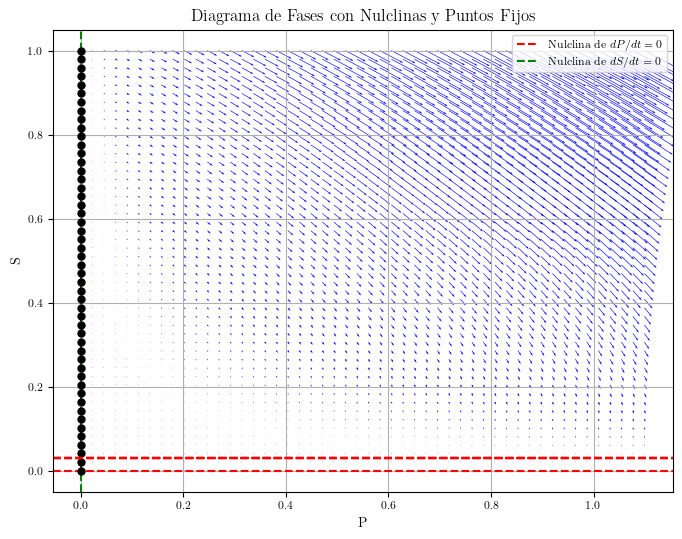

In [225]:
# Graficar el diagrama de fases con nulclinas y puntos fijos
plt.figure(figsize=(8, 6))
# plt.quiver(P_grid, S_grid, dP_vals, dS_vals, color='blue', alpha=0.5,scale=1, width=0.005)
plt.quiver(P_grid, S_grid, dP_vals, dS_vals, color='blue',scale=500, width=0.001)


# Graficar las nulclinas (solo como ejemplo)
plt.axhline(0, color='r', linestyle='--', label='Nulclina de $dP/dt = 0$')
plt.axvline(0, color='g', linestyle='--', label='Nulclina de $dS/dt = 0$')

# Graficar los puntos fijos
for point in fixed_points:
    P_val, S_val = point
    plt.plot(P_val, S_val, 'ko', markersize=5)

for nulclina_P in S_roots:
    plt.axhline(nulclina_P, color='r', linestyle='--')



plt.xlabel('P')
plt.ylabel('S')
plt.title('Diagrama de Fases con Nulclinas y Puntos Fijos')
# plt.ylim(0,1)
# plt.xlim(0,1)

plt.legend()
plt.grid()
plt.show()

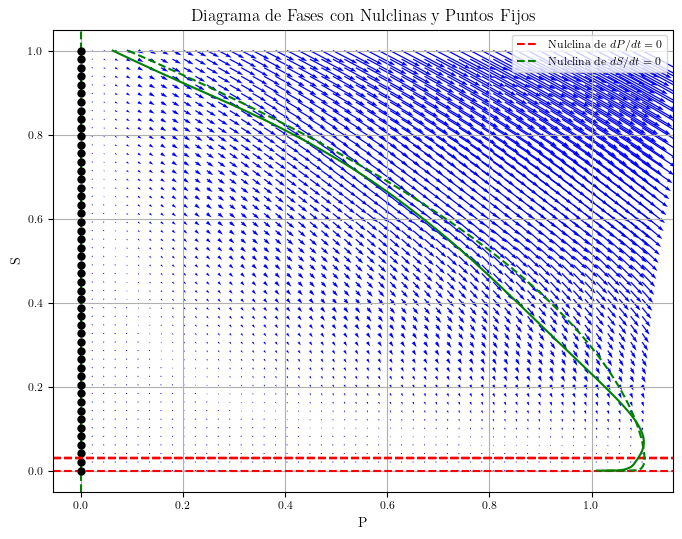

In [228]:
# Graficar el diagrama de fases con nulclinas y puntos fijos
plt.figure(figsize=(8, 6))
# plt.quiver(P_grid, S_grid, dP_vals, dS_vals, color='blue', alpha=0.5,scale=1, width=0.005)
plt.quiver(P_grid, S_grid, dP_vals, dS_vals, color='blue',scale=400, width=0.002)


# Graficar las nulclinas (solo como ejemplo)
plt.axhline(0, color='r', linestyle='--', label='Nulclina de $dP/dt = 0$')
plt.axvline(0, color='g', linestyle='--', label='Nulclina de $dS/dt = 0$')

# Graficar los puntos fijos
for point in fixed_points:
    P_val, S_val = point
    plt.plot(P_val, S_val, 'ko', markersize=5)

for nulclina_P in S_roots:
    plt.axhline(nulclina_P, color='r', linestyle='--')


plt.plot(P_int, S_int, color='green')
plt.plot(P_symb, S_symb, linestyle='--',color='green')

plt.xlabel('P')
plt.ylabel('S')
plt.title('Diagrama de Fases con Nulclinas y Puntos Fijos')
plt.legend()
# plt.ylim(0,1)
# plt.xlim(0,1)
plt.grid()
plt.show()